In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from bayesbridge import BayesBridge
from simulate_data import simulate_design, simulate_outcome

## BayesBridge supports both dense (numpy array) and sparse (scipy sparse matrix) design matrices.

In [3]:
n_obs, n_pred = 10 ** 4, 10 ** 3

X = simulate_design(
    n_obs, n_pred, 
    corr_dense_design=False,
    binary_frac=.6, 
    binary_pred_freq=.2,
    categorical_frac=.3, 
    n_category=5,
    shuffle_columns=True,
    format_='sparse',
    seed=0
)
X = sp.sparse.hstack((np.ones((n_obs, 1)), X)) # Manually add an intercept. 

In [4]:
n_signal = 10
intercept = 2

beta_true = np.zeros(n_pred + 1)
beta_true[0] = intercept
beta_true[1:(1 + n_signal)] = 1

n_trial = np.ones(X.shape[0]) # Binary outcome.
y = simulate_outcome(X, beta_true, model='logit', n_trial=n_trial, seed=1)

## The regression coefficients corresponding to the first 'n_coef_without_shrinkage' columns of the design matrix are given Gaussian (not shrinkage) priors.

In [5]:
bridge = BayesBridge(
    y, X, model='logit',
    add_intercept=False, 
        # We manually added the intercept to X
    n_coef_without_shrinkage=1, 
        # Don't shrink the intercept
    prior_sd_for_unshrunk=np.array([float('inf')]) 
        # Set it to float('inf') for a flat prior.
)

/Users/aki-nishimura/Dropbox/Documents_Academic/CG accelerated Gibbs/Code/bayesbridge/util/simple_warnings.py:5: UserWarning: The numbers of trials were not specified. The binary outcome is assumed.


## Run the Gibbs sampler. The BayesBridge uses a prior $ \pi(\beta_j \, | \, \tau) \propto \tau^{-1} \exp\left( - \, \left| \tau^{-1} \beta_j \right|^\alpha \right) $ for $0 < \alpha \leq 1$. The default is $\alpha = 1 / 2$.

In [6]:
mcmc_output = bridge.gibbs(
    n_burnin=0, n_post_burnin=250, thin=1, 
    init={'global_shrinkage': .01},
    mvnorm_method='cg',
    seed=2
)
samples = mcmc_output['samples']

#### Check the convergence by looking at the traceplot for posterior log-density.

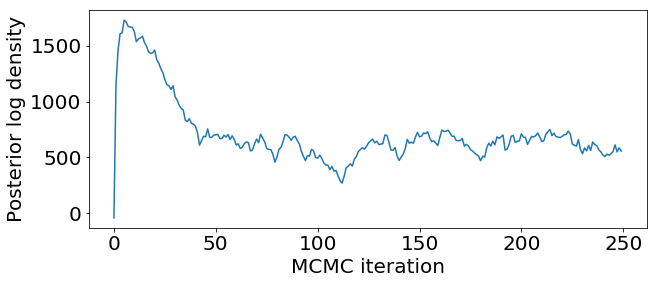

In [7]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

## Restart MCMC from the last iteration with the 'gibbs_additional_iter' method.

In [8]:
mcmc_output = bridge.gibbs_additional_iter(
    mcmc_output, n_iter=250
)
samples = mcmc_output['samples']

#### Check the convergence again.

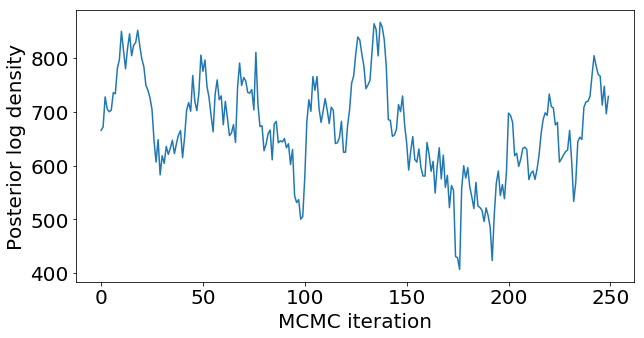

In [9]:
plt.figure(figsize=(10, 5))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

## Add more samples (while keeping the previous ones) with the option 'merge=True'.

In [10]:
mcmc_output = bridge.gibbs_additional_iter(
    mcmc_output, n_iter=750, merge=True
)
samples = mcmc_output['samples']

#### Mixing of the regression coefficients are adequate for most practical purposes. Mixing of the global shrinkage parameter (and hence the log-density) leaves something to be desired, but it is no as long as the global shrinkage parameter has converged, over empirical Bayes.

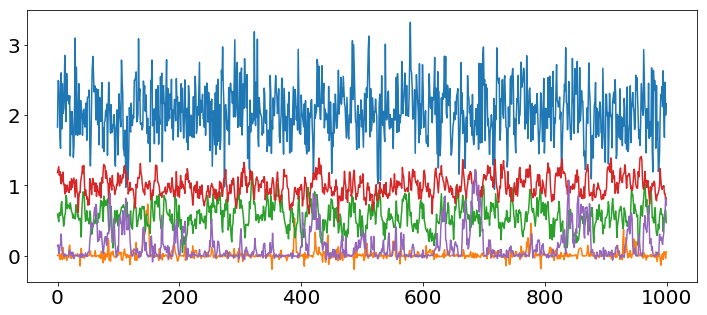

In [11]:
plt.figure(figsize=(12, 5))
plt.rcParams['font.size'] = 20

plt.plot(samples['beta'][:5, :].T)
plt.show()

#### The posterior means of the regression coefficients mostly recover the true values. It seems like there is not enough statistical power, however, and some non-zero coefficients are shrunk toward zero.

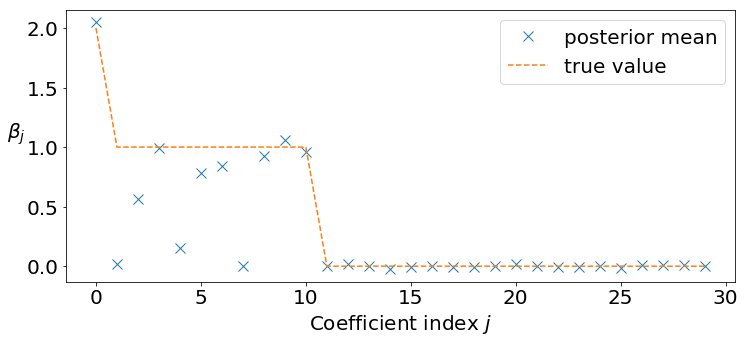

In [12]:
plt.figure(figsize=(12, 5))
plt.rcParams['font.size'] = 20

n_coef_to_plot = 30
beta_post_mean = np.mean(samples['beta'], -1)
plt.plot(beta_post_mean[:n_coef_to_plot], 'x', ms=10)
plt.plot(beta_true[:n_coef_to_plot], '--')
plt.xlabel(r'Coefficient index $j$')
plt.ylabel(r'$\beta_j$', rotation=0, labelpad=10)
plt.legend(['posterior mean', 'true value'])
plt.show()